In [1]:
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import numpy as np
import everest

# Download the data
star = everest.Everest(204832142, quiet = True)

In [2]:
everest.__version__

'2.0.8'

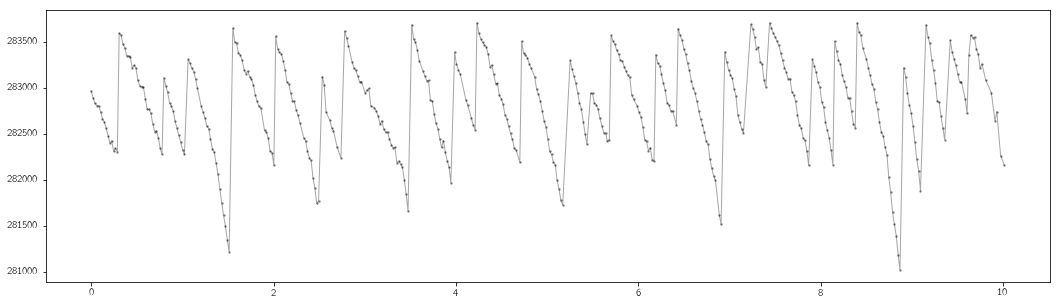

In [3]:
# Remove outliers, get a nice subset of the data
cut = range(300,755)
t = star.apply_mask(star.time)[cut]
F = star.apply_mask(star.fpix)[cut]
t -= t[0]

# Remove additional ugly outliers
delete = [51, 119, 128, 186, 237, 316, 328, 329, 330, 409, 420]
t = np.delete(t, delete)
F = np.delete(F, delete, axis = 0)

# Plot the raw flux
fig = pl.figure(figsize = (18,5))
pl.plot(t, np.sum(F, axis = 1), 'k.-', alpha = 0.35, ms = 3, lw = 1);

In [4]:
# Define a simple transit model
def transit(t):
    return everest.TransitShape(depth = 0.001, dur = 0.25)(t - 2.) + \
           everest.TransitShape(depth = 0.001, dur = 0.25)(t - 5.) + \
           everest.TransitShape(depth = 0.001, dur = 0.25)(t - 8.) + 1.

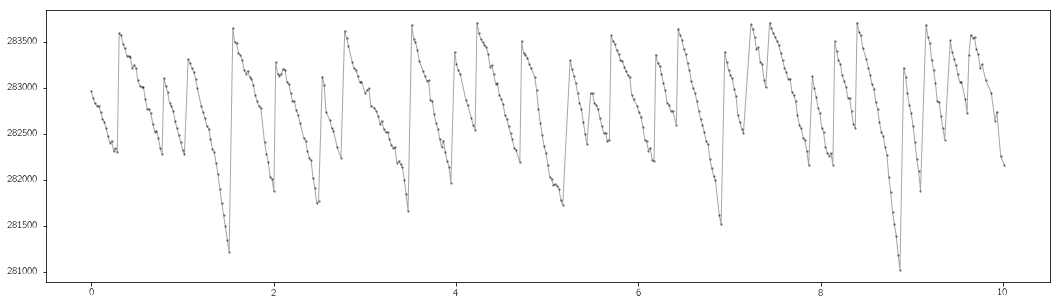

In [5]:
# Plot the flux w/ the injected transit
fig = pl.figure(figsize = (18,5))
trn = transit(t)
mask = np.where(trn < 1)[0]
Finj = trn.reshape(-1,1) * F
pl.plot(t, np.sum(Finj, axis = 1), 'k.-', alpha = 0.35, ms = 3, lw = 1);

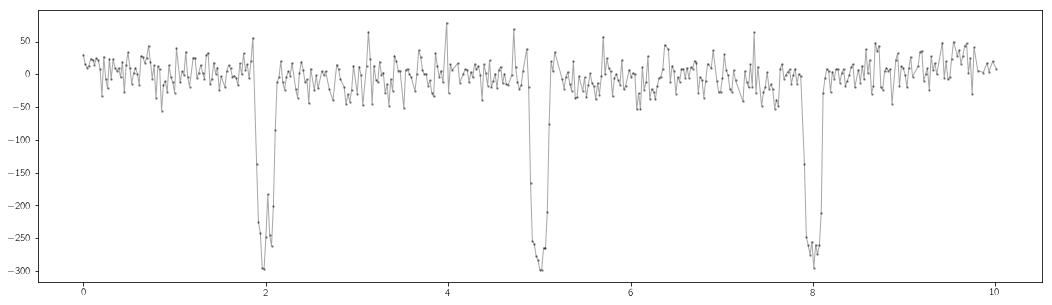

In [6]:
# Get the first order PLD model
X = Finj / np.sum(Finj, axis = 1).reshape(-1,1)
mX = np.delete(X, mask, axis = 0)
weights = np.linalg.solve(np.dot(mX.T, mX), np.dot(mX.T, np.delete(np.sum(Finj, axis = 1), mask)))
model = np.dot(X, weights)

# Plot it
fig = pl.figure(figsize = (18,5))
pl.plot(t, np.sum(Finj, axis = 1) - model, 'k.-', alpha = 0.35, ms = 3, lw = 1);

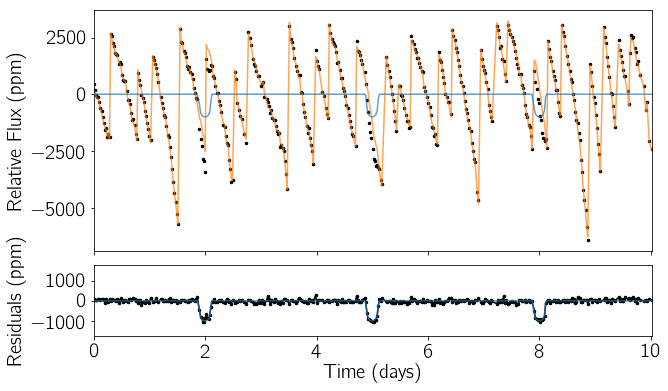

In [16]:
# Normalize
Fsap = np.sum(Finj, axis = 1)
med = np.nanmedian(Fsap)
Fsap /= med
mnorm = model / med

# Convert to ppt
to_ppm = lambda x: (x - 1) * 1e6

# Make pretty
mpl.rcParams["font.size"] = 20
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "Computer Modern Sans"
mpl.rcParams["text.latex.preamble"] = "\\usepackage{cmbright}"

# Plot the figure
fig = pl.figure(figsize = (10, 6))
ax0 = pl.subplot2grid((4, 1), (0, 0), colspan = 1, rowspan = 3)
ax1 = pl.subplot2grid((4, 1), (3, 0), colspan = 1, rowspan = 1)
ax = [ax0, ax1]
ms = 5
lw = 1.5
ax[0].plot(t, to_ppm(trn), '-', color = None, alpha = 0.7, ms = ms, lw = lw, zorder = 99);
ax[0].plot(t, to_ppm(Fsap), '.', color = 'k', ms = ms, lw = lw);
ax[0].plot(t, to_ppm(mnorm), '-', color = None, alpha = 0.7, ms = ms, lw = lw);
ax[1].plot(t, to_ppm(1 + Fsap - mnorm), '.-', color = 'k', ms = ms, lw = lw);
ax[1].plot(t, to_ppm(trn), '-', color = None, alpha = 0.7, ms = ms, lw = lw);

# Labels
ax[0].set_ylabel('Relative Flux (ppm)')
ax[1].set_ylabel('Residuals (ppm)')
ax[1].set_xlabel('Time (days)')

# More make pretty
ax[0].margins(0, None);
ax[1].margins(0, None);
ax[0].get_yaxis().set_major_locator(MaxNLocator(5, integer = True))
ax[0].set_xticklabels([]);

# Fix axis limits so the two panels have the same scale
ax0lim = ax[0].get_ylim()
ax0rng = ax0lim[1] - ax0lim[0]
ax1.set_ylim(-0.5 * (1 / 3) * ax0rng, 0.5 * (1 / 3) * ax0rng);

fig.savefig("figure.pdf", bbox_inches="tight")